<a href="https://colab.research.google.com/github/faizanfaiz11422/PINNverse/blob/main/Falkner-Skan-PINNS/Falkner_Skan_PINN_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

In [ ]:
# 📂 Step 2: Load Analytic Solution
try:
    if not os.path.exists("mydata1.csv"):
        raise FileNotFoundError("Missing 'mydata1.csv'. Please upload it.")

    data = pd.read_csv("mydata1.csv", header=None)
    if data.empty or data.shape[1] < 2:
        raise ValueError("CSV must contain at least two columns.")

    analytic_eta = tf.constant(data.iloc[:, 0].values.reshape(-1, 1), dtype=tf.float32)
    analytic_theta = tf.constant(data.iloc[:, 1].values.reshape(-1, 1), dtype=tf.float32)
    print("✅ Analytic data loaded successfully.")

except Exception as e:
    print(f"❌ Error loading CSV: {e}")
    exit()


In [ ]:
# ⚙️ Step 3: Define Physical Parameters
PRANDTL = 1.0
LAMBDA = 1.5

In [ ]:
# 🧠 Step 4: Build PINN Model
def build_model():
    inputs = tf.keras.Input(shape=(1,), name="eta")
    # Increased network size for better learning capacity
    x = tf.keras.layers.Dense(128, activation="relu")(inputs)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dense(128, activation="tanh")(x)
    f_out = tf.keras.layers.Dense(1, name="f")(x)
    theta_out = tf.keras.layers.Dense(1, name="theta")(x)
    return tf.keras.Model(inputs=inputs, outputs=[f_out, theta_out])

model = build_model()
model.summary()

In [ ]:
# 📉 Step 5: R² Score Function
def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true.numpy().flatten() - y_pred.numpy().flatten()) ** 2)
    ss_tot = np.sum((y_true.numpy().flatten() - np.mean(y_true.numpy().flatten())) ** 2)
    return 1 - (ss_res / ss_tot) if ss_tot > 0 else 0

In [ ]:
# 📉 Step 6: Loss Function
@tf.function
def compute_loss(eta):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch(eta)

        # Forward pass to get f and theta
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch(eta)
            f, theta = model(eta)

        # Compute first derivatives
        f1 = tape2.gradient(f, eta)
        theta1 = tape2.gradient(theta, eta)
        del tape2

        # Compute second and third derivatives
        f2 = tape1.gradient(f1, eta)
        theta2 = tape1.gradient(theta1, eta)
        f3 = tape1.gradient(f2, eta)
        del tape1

    # Physics residuals (R1 and R2) - REVERTED TO FALKNER-SKAN EQUATIONS
    # R1: f''' + f f'' - (f')^2 + lambda theta = 0
    # R2: theta'' + Pr f theta' = 0
    R1 = f3 + f * f2 - f1**2 + LAMBDA * theta
    R2 = theta2 + PRANDTL * f * theta1
    physics_loss = tf.reduce_mean(tf.square(R1)) + tf.reduce_mean(tf.square(R2))

    # Boundary conditions
    eta_0 = tf.constant([[0.0]], dtype=tf.float32)
    eta_inf = tf.constant([[10.0]], dtype=tf.float32)

    with tf.GradientTape() as tape_bc0:
        tape_bc0.watch(eta_0)
        f0, theta0 = model(eta_0)
        f1_0 = tape_bc0.gradient(f0, eta_0)

    with tf.GradientTape() as tape_bc_inf:
        tape_bc_inf.watch(eta_inf)
        f_inf, theta_inf = model(eta_inf)
        f1_inf = tape_bc_inf.gradient(f_inf, eta_inf)

    # Boundary condition loss terms
    bc_loss = tf.square(f0) + tf.square(f1_0) + tf.square(theta0 - 1.0) + \
              tf.square(f1_inf - 1.0) + tf.square(theta_inf)

    # Supervised data loss
    _, theta_pred = model(analytic_eta)
    data_loss = tf.reduce_mean(tf.square(theta_pred - analytic_theta))

    return physics_loss, bc_loss, data_loss, theta_pred

In [ ]:
# 🏋️ Step 7: Training Loop
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
EPOCHS = 3000
history = []

PHYSICS_LOSS_WEIGHT = 10.0
DATA_LOSS_WEIGHT = 10.0

train_eta = tf.random.uniform((500, 1), minval=0.0, maxval=10.0)

for epoch in range(EPOCHS):
    with tf.GradientTape() as tape:
        physics_loss, bc_loss, data_loss, theta_pred = compute_loss(train_eta)
        total_loss = PHYSICS_LOSS_WEIGHT * physics_loss + bc_loss + DATA_LOSS_WEIGHT * data_loss
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    history.append(total_loss.numpy().item())

    if epoch % 100 == 0:
        r2 = r2_score(analytic_theta, theta_pred)
        print(f"Epoch {epoch}: Total = {total_loss.numpy().item():.6f}, "
              f"Physics = {physics_loss.numpy().item():.6f}, "
              f"BC = {bc_loss.numpy().item():.6f}, "
              f"Data = {data_loss.numpy().item():.6f}, R² = {r2:.4f}")

print("✅ Training complete!")

TensorFlow Version: 2.19.0
GPU Available: []
✅ Analytic data loaded successfully.


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ eta (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_66 (Dense)    │ (None, 128)       │        256 │ eta[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_67 (Dense)    │ (None, 128)       │     16,512 │ dense_66[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_68 (Dense)    │ (None, 128)       │     16,512 │ dense_67[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ f (Dense)           │ (None, 1)         │        129 │ dense_68[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ theta (Dense)       │ (None, 1)         │        129 │ dense_68[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,538 (131.01 KB)

 Trainable params: 33,538 (131.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 0: Total = 19.536171, Physics = 1.260569, BC = 3.161259, Data = 0.376922, R² = -17.0003
Epoch 100: Total = 0.485911, Physics = 0.009141, BC = 0.389163, Data = 0.000534, R² = 0.9745
Epoch 200: Total = 0.403873, Physics = 0.009490, BC = 0.301959, Data = 0.000702, R² = 0.9665
Epoch 300: Total = 0.513543, Physics = 0.011688, BC = 0.354222, Data = 0.004244, R² = 0.7973
Epoch 400: Total = 0.398741, Physics = 0.008660, BC = 0.295820, Data = 0.001632, R² = 0.9220
Epoch 500: Total = 0.685697, Physics = 0.036727, BC = 0.249632, Data = 0.006879, R² = 0.6715
Epoch 600: Total = 0.548366, Physics = 0.022486, BC = 0.303555, Data = 0.001995, R² = 0.9047
Epoch 700: Total = 0.653292, Physics = 0.036444, BC = 0.243683, Data = 0.004517, R² = 0.7843
Epoch 800: Total = 0.654168, Physics = 0.037859, BC = 0.236985, Data = 0.003859, R² = 0.8157
Epoch 900: Total = 0.813923, Physics = 0.033806, BC = 0.441433, Data = 0.003443, R² = 0.8356
Epoch 1000: Total = 0.644875, Physics = 0.041495, BC = 0.191889, Data

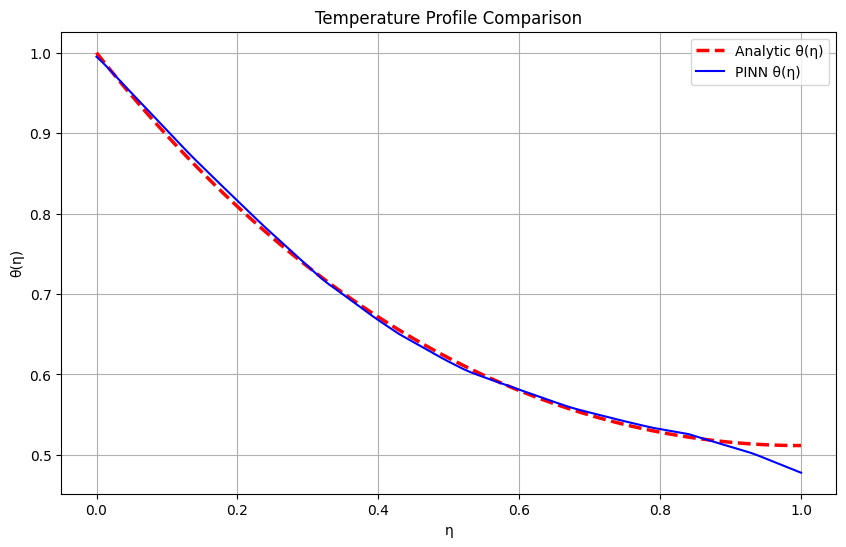

📈 Final RMSE: 0.007777
📊 Final R² Score: 0.9971


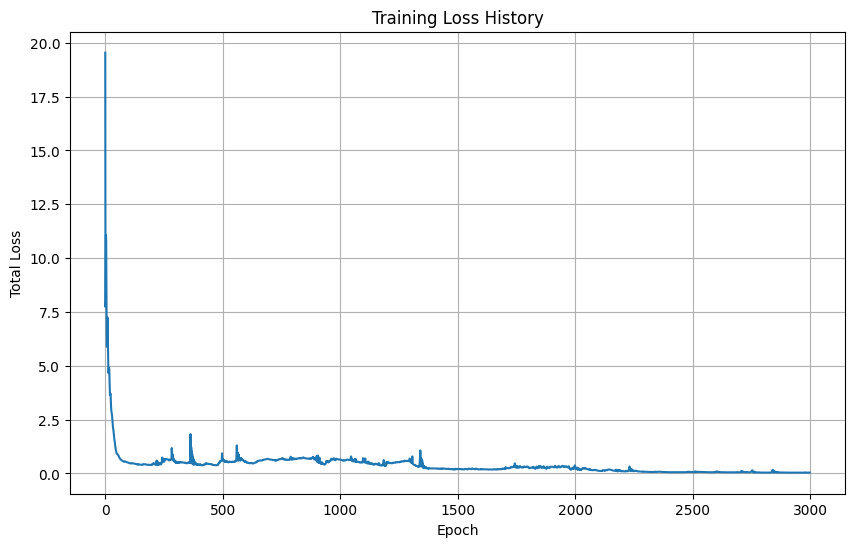

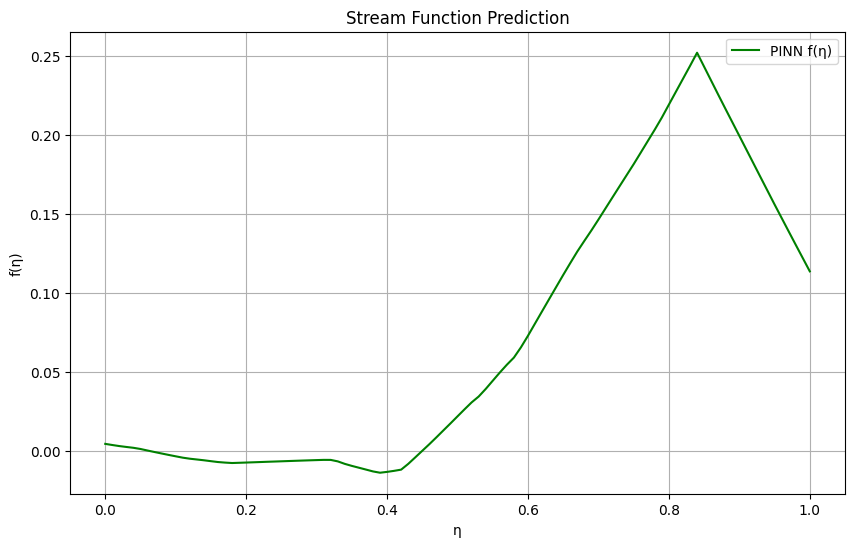

In [ ]:
# 📊 Step 8: Validation & Visualization
f_pred, theta_pred = model(analytic_eta)

plt.figure(figsize=(10, 6))
plt.plot(analytic_eta, analytic_theta, 'r--', label='Analytic θ(η)', linewidth=2.5)
plt.plot(analytic_eta, theta_pred.numpy(), 'b-', label='PINN θ(η)', linewidth=1.5)
plt.title("Temperature Profile Comparison")
plt.xlabel("η")
plt.ylabel("θ(η)")
plt.legend()
plt.grid(True)
plt.show()

rmse = np.sqrt(np.mean((analytic_theta.numpy() - theta_pred.numpy())**2))
r2_final = r2_score(analytic_theta, theta_pred)
print(f"📈 Final RMSE: {rmse:.6f}")
print(f"📊 Final R² Score: {r2_final:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(EPOCHS), history)
plt.title("Training Loss History")
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.grid(True)
plt.show()

f_pred, _ = model(analytic_eta)
plt.figure(figsize=(10, 6))
plt.plot(analytic_eta, f_pred.numpy(), 'g-', label='PINN f(η)')
plt.title("Stream Function Prediction")
plt.xlabel("η")
plt.ylabel("f(η)")
plt.legend()
plt.grid(True)
plt.show()



































CoPilot